

# STEP 1 - PLACE TO DISTANCE RISK SCORE CALCULATION FOR NORTHRIDGE

##### Created by - Sanjana Tule 
##### Date - 14/08/2021



> Choose a place , fetch the graph, segment the buildings, calcualte distance transform, and save in the new graph in pickle file




In [1]:
# !pip install osmnx
# !apt install python3-rtree

In [2]:
# importing libraries
import matplotlib.pyplot as plt
import osmnx as ox
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from scipy.ndimage import distance_transform_edt
import pandas as pd
import itertools
import matplotlib
import networkx as nx
import folium
import statistics

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


STEP 1 - GET OSMNX GRAPH, LAT MIN/MAX, LON MIN/MAX, AREA

Latitudes are min: 34.2318696 and max: 34.2824454
Longitudes are min: -118.5621743 and max: -118.6476876


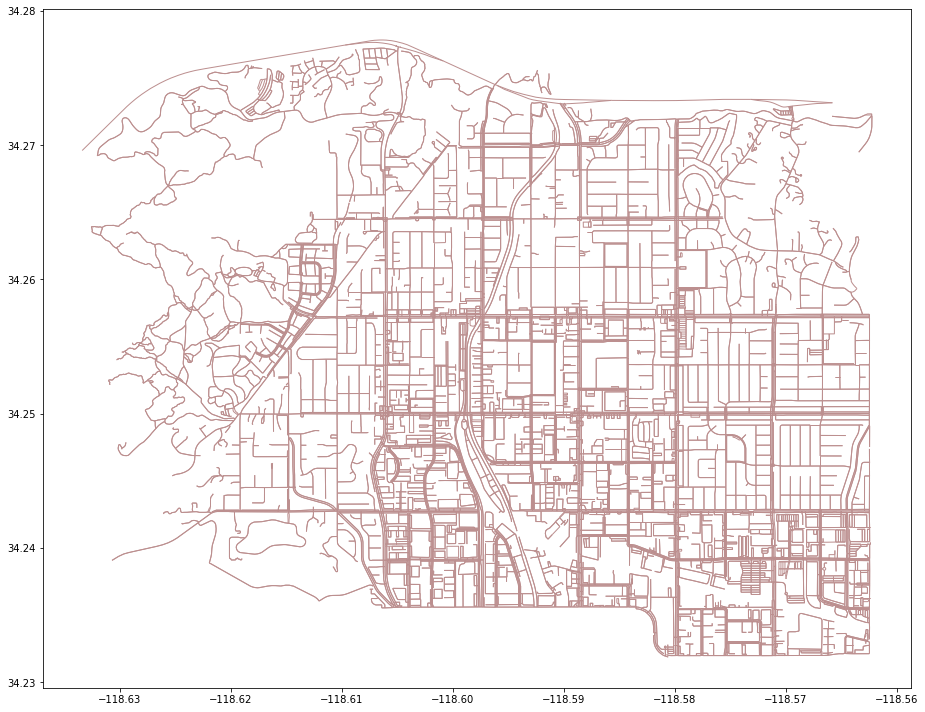

In [4]:
# STEP 1 - For a place, get the graph, area

place = "Chatsworth, California, USA"
fig, ax = plt.subplots(figsize=(20,10))

# get the graph from place
G_northridge_all   = ox.graph_from_place(place)

# get street edges
nodes,edges = ox.graph_to_gdfs(G_northridge_all)
edges.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')
plt.tight_layout()

# get the area ( will need later for plotting )
northridge_gdf = ox.geocode_to_gdf(place)

# get buildings from place
buildings_northridge_all   = ox.geometries_from_place(place, {'building':True})

# get the latitude and longitude of the area
lon_max, lon_min = northridge_gdf[['bbox_west']].values[0][0], northridge_gdf[['bbox_east']].values[0][0]
lat_max, lat_min = northridge_gdf[['bbox_north']].values[0][0], northridge_gdf[['bbox_south']].values[0][0]

print('Latitudes are min: {} and max: {}'.format(lat_min,lat_max))
print('Longitudes are min: {} and max: {}'.format(lon_min,lon_max))

STEP 1 - GET OSMNX GRAPH, LAT MIN/MAX, LON MIN/MAX, AREA BY BOX BOUNDED BY LAT/LONG

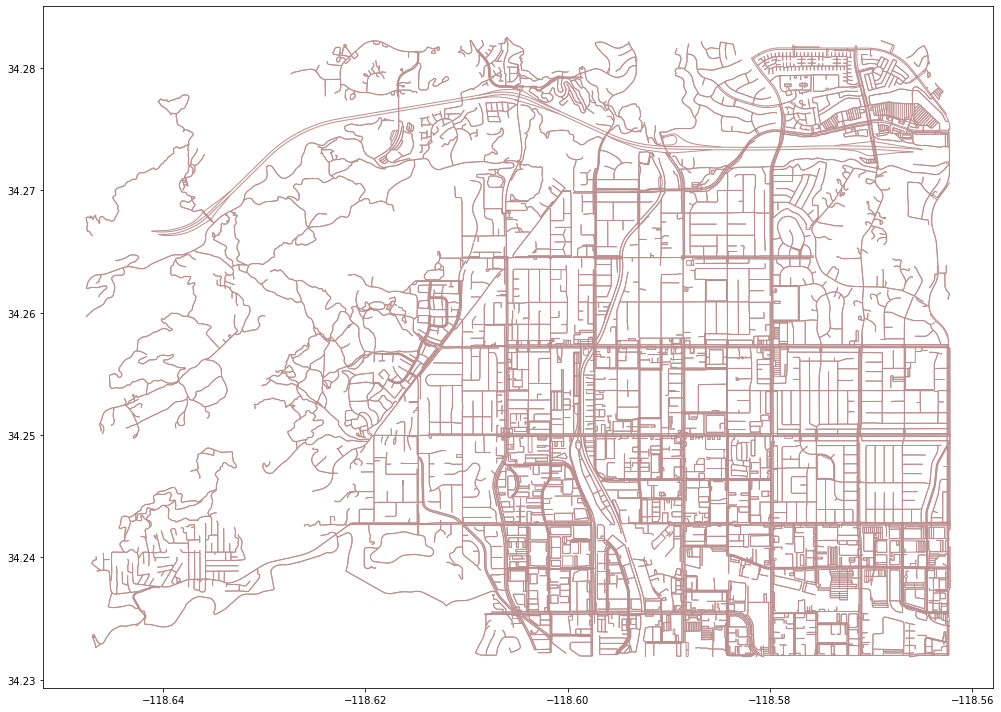

In [5]:
# construct box for distance transformation  as irregular shape does not give correct distances.
fig, ax = plt.subplots(figsize=(20,10))
G_northridge_box_graph = ox.graph_from_bbox(lat_min,lat_max,lon_min,lon_max)
nodes_box,edges_box = ox.graph_to_gdfs(G_northridge_box_graph)
northridge_box_gdf = ox.geocode_to_gdf(place)
edges_box.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')
plt.tight_layout()

STEP 2 - GET FOOTPRINT OF THE BUILDING AND PLOT

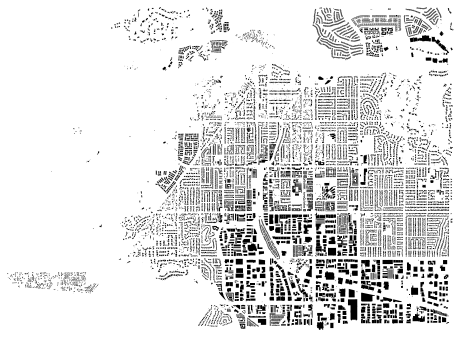

<Axes:>

In [6]:
# get the buildings footprint for the box above and save the file

buildings_northridge_box   = ox.geometries_from_bbox(lat_min,lat_max,lon_min,lon_max, {'building':True})

fig, ax = ox.plot_footprints(buildings_northridge_box, figsize=(8, 8),color='black',bgcolor='#FFFFFF',save =True, filepath ='/content/gdrive/My Drive/omdena/earthquake/buildings_northridge_segmented.png',dpi=100)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

STEP 3 - CONVERT IMAGE INTO BINARY IMAGE

Shape of original image (448, 619)


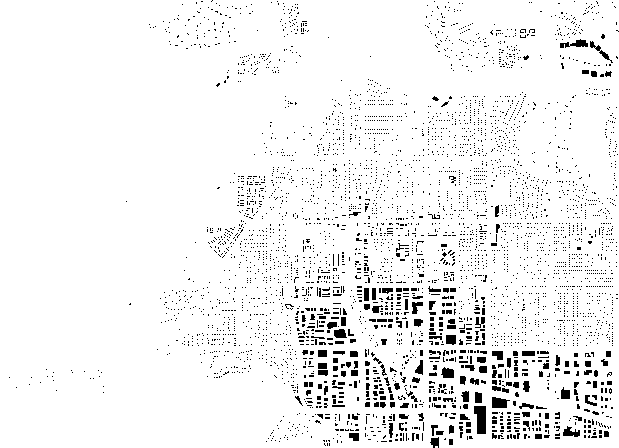

Shape of binary image (448, 619)


In [7]:
# read as grayscale image of building footprint
northridge_building_segmented = '/content/gdrive/My Drive/omdena/earthquake/buildings_northridge_segmented.png'
img = cv2.imread(northridge_building_segmented,0)
print("Shape of original image",img.shape)
ret, bw_img = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
cv2_imshow (bw_img)
np.unique(bw_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
print("Shape of binary image",bw_img.shape)

STEP 4 - APPLY DISTANCE TRANSFORMATION ON IMAGE

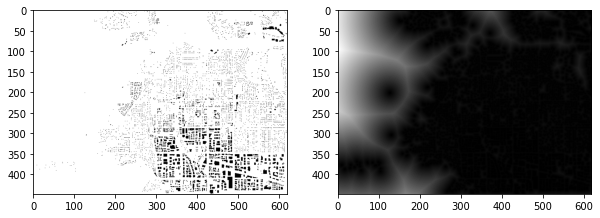

In [8]:
# apply distance transformation
distance = distance_transform_edt(bw_img)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(bw_img,cmap = plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(distance,cmap = plt.cm.gray)
plt.show()

distance.shape
distance = np.round(distance)

# save distance transform into umpy array
np.save('/content/gdrive/My Drive/omdena/earthquake/northridge_np_distance_transform.npy',distance,allow_pickle=True)

In [ ]:
distance.shape

(603, 614)

In [ ]:
distance

array([[ 9.,  8.,  8., ...,  7.,  7.,  8.],
       [ 9.,  8.,  7., ...,  6.,  6.,  7.],
       [ 8.,  7.,  6., ...,  5.,  5.,  6.],
       ...,
       [17., 17., 17., ..., 31., 32., 32.],
       [18., 18., 18., ..., 31., 32., 33.],
       [19., 19., 19., ..., 32., 33., 34.]])

STEP 5 - CONVERT DISTANCE TRANSFORM INTO LONGITUTDE/LATITUDE VALUES

In [9]:
# merge the distance transform and the osmnx graph
summary = pd.DataFrame({'Name': ['x','y'],'max': [lon_max, lat_max],'min': [lon_min, lat_min]}).set_index('Name')
summary['np_matrix pixels'] = [distance.shape[1], distance.shape[0]] 
display(summary)

# generate latitude and longitude evenly spaced
lat_index = np.flip(np.linspace(summary['min'].y,summary['max'].y,summary['np_matrix pixels'].y))
lon_index = np.linspace(summary['min'].x,summary['max'].x,summary['np_matrix pixels'].x) 


,max,min,np_matrix pixels
Name,,,
x,-118.647688,-118.562174,619
y,34.282445,34.231870,448


In [10]:
def Line_to_list_lonlats(geom, summary, lon_index, lat_index):
  #geom.bounds is a tuple consisting of (lower_lat, lower_lon, upper_lat, upper_lon)
  delta_x = geom.bounds[2]-geom.bounds[0]
  delta_y = geom.bounds[3]-geom.bounds[1]
  #print("delta_x",delta_x)
  #print("delta_y",delta_y)
  steps_num = int(np.ceil(max(delta_x/abs(lon_index[1]-lon_index[0]), delta_y/abs(lat_index[1]-lat_index[0]))))
  #print("steps_num",steps_num)
  coords_list = [geom.interpolate(i, normalized=True).coords[0] for i in np.linspace(0,1,steps_num)]
  return coords_list

def lonlat_to_xy_to_values(list_, summary, lon_index, lat_index, np_matrix, filter_size = 1):
  list_x = [i[0] for i in list_]
  lon_min = lon_index.min()  
  list_x = [x if x >= lon_min else lon_min for x in list_x ]
  lon_max = lon_index.max()
  list_x = [x if x <= lon_max else lon_max for x in list_x ]
  

  list_y = [i[1] for i in list_]
  lat_min = lat_index.min() 
  list_y = [y if y >= lat_min else lat_min for y in list_y ]
  lat_max = lat_index.max()
  list_y = [y if y <= lat_max else lat_max for y in list_y ]


  x = [np.nonzero((lon>=lon_index))[0][-1] for lon in list_x] 
  y = [np.nonzero((lat>=lat_index))[0][0] for lat in list_y]

  point_distance = []
  for i,v in zip(x,y):
    #print("i:{} and v:{}".format(i,v))
    temp=[]
    for j in itertools.product(range(i-1,i+2),range(v-1,v+2)):
      if (j[1]<np_matrix.shape[0])&(j[0]<np_matrix.shape[1]) and j[0] >=0 and j[1] >=0:
        #print("j[0]:{} and j[1]:{}".format(j[0],j[1]))
        #print("matrix value",np_matrix[j[1],j[0]])
        temp.append(np_matrix[j[1],j[0]])
    #print("distance array",temp)
    #print("max",max(temp))
    point_distance.append(max(temp))
    #print("point_distance",point_distance)

  #arrays = [np.array([np_matrix[j[1],j[0]] if (j[0]<np_matrix.shape[1])&(j[1]<np_matrix.shape[1]) else 0 for j in itertools.product(range(i-filter_size,i+filter_size+1),range(v-filter_size,v+filter_size+1))]).min() for i,v in zip(x,y)]
  
  x_y = [[i,v] for i,v in zip(x,y)]
  # print("x_y",x_y)
  lon_lat = [[i,v] for i,v in zip(list_x,list_y)]
  # print("lon_lat",lon_lat)
  return point_distance, x_y, lon_lat

def extract_value_from_matrix(geom, summary, lat_index, lon_index, np_matrix, filter_size = 1):
  #print("geom",geom)
  list_ = Line_to_list_lonlats(geom, summary, lon_index, lat_index)
  #print("list",list_)
  assert len(list_) > 0, 'list is empty'
  arrays, x_y, lon_lat = lonlat_to_xy_to_values(list_, summary, lon_index, lat_index, np_matrix, filter_size)
  return {'sampling_counts': len(arrays),
          'max': max(arrays),
          'min': min(arrays),
          'mean': sum(arrays)/len(arrays),
          'median': statistics.median(arrays),
          'x_y': x_y,
          'lon_lat': lon_lat}

STEP 6 - FOR EACH EDGE FIND THE LONG /LAT VALUES AND FETCH DISTANCE TRANSFORM VALUE FROM DISTANCE MATRIX

In [11]:
# get information for every edge in the graph
_ = edges.geometry.apply(lambda x: extract_value_from_matrix(x, summary, lat_index, lon_index, distance, filter_size = 1))

# merge the additional information with the existing edges dataframe
edges_extended = edges.merge(pd.DataFrame({ 'sampling_counts' : _.apply(lambda x: x['sampling_counts']),
                                          'max': _.apply(lambda x: x['max']),
                                          'min': _.apply(lambda x: x['min']),
                                          'mean': _.apply(lambda x: x['mean']),
                                          'median': _.apply(lambda x: x['median']),
                                          'x_y': _.apply(lambda x: x['x_y']),
                                          'lon_lat': _.apply(lambda x: x['lon_lat'])}), left_index=True, right_index=True)

In [12]:
edges_extended.head()

osmid  ...                                            lon_lat
u         v          key                          ...                                                   
21569692  6784129514 0                 401489877  ...  [[-118.604826, 34.2722948], [-118.6049912, 34....
          6784129512 0                 401489883  ...                        [[-118.604826, 34.2722948]]
          4682380491 0    [185913115, 401489878]  ...  [[-118.604826, 34.2722948], [-118.604890884031...
122455907 3902625479 0                  13265268  ...  [[-118.5991707, 34.2725068], [-118.59918569201...
          122462830  0                  13266267  ...  [[-118.5991707, 34.2725068], [-118.59898087447...

[5 rows x 21 columns]

STEP 7 - CALCULATE DISTANCE RISK SCORE,BUILDING DENSITY RISK SCORE FOR EACH EDGE

In [17]:
# calculate mean and median distance for each edge and choose the one which is the minimum value
edges_extended['mean_scaled'] = edges_extended['mean'].apply(lambda x: np.exp(np.interp(x, (edges_extended['mean'].min(), edges_extended['mean'].max()), (0, 5))))
edges_extended['median_scaled'] = edges_extended['median'].apply(lambda x: np.exp(np.interp(x, (edges_extended['median'].min(), edges_extended['median'].max()), (0, 5))))
edges_extended['mean_scaled_inversed'] = edges_extended['mean_scaled'].apply(lambda x: abs(x - edges_extended['mean_scaled'].max()))
edges_extended['median_scaled_inversed'] = edges_extended['median_scaled'].apply(lambda x: abs(x - edges_extended['median_scaled'].max()))
#edges_extended['distance_risk_score'] = edges_extended[['mean_scaled_inversed','median_scaled_inversed']].apply(lambda x: min(x[0],x[1]),axis=1)
edges_extended['distance_risk_score'] = edges_extended['max'].apply(lambda x: abs(x - edges_extended['max'].max()))
# add color to the edge based on risk_score
def color_func(x):
    if x <= 15:
        col = 'blue'
    elif x <= 26:
        col = 'yellow'
    else:
        col = 'red'
    return col 

edges_extended['edge_color'] = edges_extended['distance_risk_score'].apply(lambda x: color_func(x))
edges_extended.head()

osmid  ... edge_color
u         v          key                          ...           
21569692  6784129514 0                 401489877  ...       blue
          6784129512 0                 401489883  ...       blue
          4682380491 0    [185913115, 401489878]  ...       blue
122455907 3902625479 0                  13265268  ...       blue
          122462830  0                  13266267  ...       blue

[5 rows x 27 columns]

STEP 8 - PLOT THE GRAPH

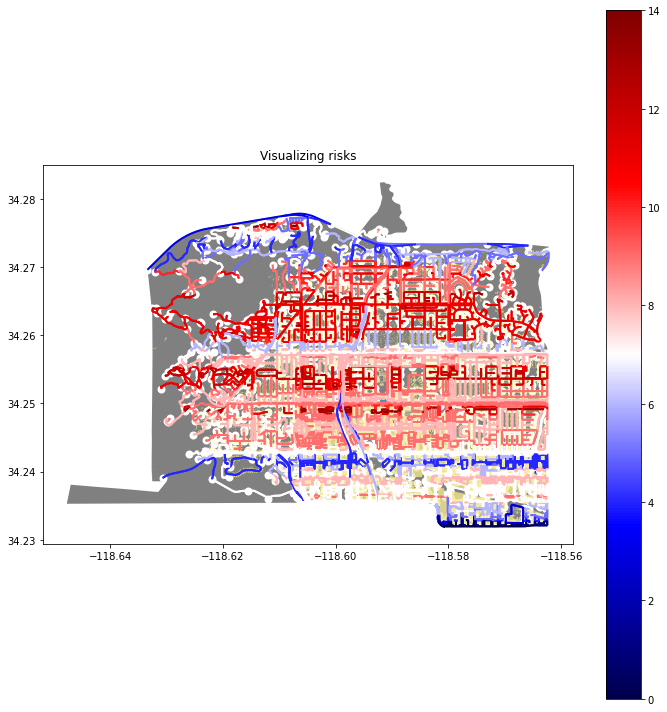

In [18]:
# convert the existing nodes and new edge information into a graph
utn = ox.settings.useful_tags_node
oxna = ox.settings.osm_xml_node_attrs
oxnt = ox.settings.osm_xml_node_tags
utw = ox.settings.useful_tags_way
oxwa = ox.settings.osm_xml_way_attrs
oxwt = ox.settings.osm_xml_way_tags
utn = list(set(utn + oxna + oxnt))
utw = list(set(utw + oxwa + oxwt))
ox.config(all_oneway=True, useful_tags_node=utn, useful_tags_way=utw)
graph_with_Building_dist = ox.graph_from_gdfs(nodes, edges_extended)

# get the geodataframe information of the graph
new_nodes,new_edges = ox.graph_to_gdfs(graph_with_Building_dist)

fig, ax = plt.subplots(figsize=(10, 10))
# plot area
northridge_gdf.plot(ax=ax, facecolor='gray')
# plot edges and nodes
new_edges.plot(ax=ax, linewidth=2, column='distance_risk_score', cmap='seismic')
new_nodes.plot(ax=ax, linewidth=2, facecolor='white')
# plot buildings
buildings_northridge_all.plot(ax=ax, facecolor='khaki', alpha=0.8)
sm = plt.cm.ScalarMappable(cmap='seismic', norm = matplotlib.colors.Normalize(vmin=new_edges['distance_risk_score'].min(), vmax=new_edges['distance_risk_score'].max()))
sm.set_array([])
fig.colorbar(sm, ax=ax)
ax.set_title('Visualizing risks')
fig.tight_layout()

In [ ]:
new_edges.head()

osmid   lanes  ... bridge tunnel
u          v          key                                  ...              
21569692   6784129514 0                 401489877       3  ...    NaN    NaN
           6784129512 0                 401489883       6  ...    NaN    NaN
           4682380491 0    [185913115, 401489878]  [5, 4]  ...    NaN    NaN
6784129514 21569692   0                 401489877       3  ...    NaN    NaN
           6784129515 0                 829194684     NaN  ...    NaN    NaN

[5 rows x 27 columns]

In [ ]:
# # plot on folium

# Run time getting disconnected - try to improve.
def find_edges(G,edge_list):
    edges_to_remove = []
    # print("Edges not to keep",edge_list)
    # print("All edges",G.edges)
    # return edges that do not match the list
    edges_to_remove = list(set(G.edges) - set(edge_list))
    return(edges_to_remove)


# Load initial graph
G_tmp = G_northridge_all.copy()
m = ox.plot_graph_folium(G_tmp, weight=5,color = 'white' )
m

for c in ['blue','red','yellow']:
  G_tmp = G_northridge_all.copy()
  G_tmp.remove_edges_from(find_edges(G_tmp,edges_extended[edges_extended['edge_color'] == c]['edge_color'].index))
  try:
    m=ox.plot_graph_folium(G_tmp,graph_map=m,weight=5,color=c)
  except:
    continue

m


STEP 9 - SAVE GRAPH FOR PATH FINDING PROCESS LATER

In [ ]:
# save the footprints, graph and gdf
nx.write_gpickle(buildings_northridge_all,'/content/gdrive/My Drive/omdena/earthquake/chatsworth_footprint.pickle')
nx.write_gpickle(graph_with_Building_dist, '/content/gdrive/My Drive/omdena/earthquake/1_1_chatsworth_graph_distance_risk_added.pickle')
nx.write_gpickle(northridge_gdf,'/content/gdrive/My Drive/omdena/earthquake/chatsworth_gdf.pickle')

/usr/local/lib/python3.7/dist-packages/networkx/utils/decorators.py:5: DeprecationWarning: write_gpickle is deprecated and will be removed in 3.0.Use ``pickle.dump(G, path, protocol)``
  import warnings
